# Pronóstico Recursivo y Cono de Incertidumbre

**Objetivo:** Avanzar del simple "testeo" (predecir el pasado) a la **Proyección Futura** (predecir lo que no ha ocurrido).

**El Reto del Futuro:**
Para predecir el precio de mañana (t+1), necesitamos el precio de hoy (t). Pero, ¿qué pasa si queremos predecir el precio en 30 días (t+30)?
* No tenemos el dato de t+29.
* **Solución:** Usamos nuestra propia predicción de t+29 como si fuera un dato real. Esto se llama **Walk-Forward** o Forecasting Recursivo.

**Metodología de la Clase:**
1.  **Ingeniería de Características Encapsulada:** Una función que podamos llamar una y otra vez.
2.  **Entrenamiento:** Usamos toda la historia disponible hasta hoy.
3.  **Bucle Recursivo:**
    * Predecir t+1.
    * Agregar predicción a la base de datos histórica.
    * Recalcular indicadores (RSI, Medias) con el nuevo dato "falso".
    * Repetir.
4.  **Cono de Incertidumbre:** El riesgo aumenta con el tiempo. Modelaremos esto matemáticamente.

## 1. Configuración e Importaciones
Preparamos el entorno. Si estamos en un notebook real, activamos gráficos inline.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Librerías de Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Configuración de Librerías Opcionales (Manejo de errores si no están instaladas)
try:
    import yfinance as yf
except ImportError:
    print("!Advertencia! yfinance no está instalado. Se usarán datos sintéticos.")
    yf = None

try:
    import holidays
except ImportError:
    holidays = None

# Configuración Visual (Magic command simulado para scripts)
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)
np.random.seed(42)

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


## 2. Obtención de Datos (Real o Sintética)
Descargamos la historia del Dólar o generamos una caminata aleatoria controlada si no hay internet.

In [2]:
def generar_datos_sinteticos(dias=1000, precio_inicial=4000):
    """Genera una serie de tiempo con tendencia y estacionalidad."""
    print("--- Generando datos sintéticos (Modo Offline) ---")
    fechas = pd.date_range(end=datetime.now(), periods=dias, freq='D')

    # Caminata aleatoria
    retornos = np.random.normal(loc=0.0002, scale=0.012, size=dias)
    precio_base = precio_inicial * np.cumprod(1 + retornos)
    df = pd.DataFrame({'fecha': fechas, 'precio': precio_base})

    # Agregar estacionalidad anual
    t = np.arange(dias)
    seasonality = np.sin(2 * np.pi * t / 365) * 100
    df['precio'] = df['precio'] + (t * 0.5) + seasonality

    return df.set_index('fecha')

def obtener_datos(ticker="COP=X", periodo="5y"):
    """Descarga datos de Yahoo Finance."""
    if yf is None: return generar_datos_sinteticos()

    print(f"Descargando datos para {ticker}...")
    try:
        df = yf.download(ticker, period=periodo, interval="1d", progress=False)
        if df.empty: raise ValueError("Datos vacíos")

        # Estandarización de columnas (yfinance cambia formatos a veces)
        if isinstance(df.columns, pd.MultiIndex):
            df = df['Close'][[ticker]].rename(columns={ticker: 'precio'})
        else:
            df = df[['Close']].rename(columns={'Close': 'precio'})

        df.index.name = 'fecha'
        # Rellenar fines de semana para evitar huecos en los Lags
        df = df.asfreq('D').ffill()
        return df
    except Exception as e:
        print(f"Error: {e}")
        return generar_datos_sinteticos()

# Ejecución
df_raw = obtener_datos()
print(f"Datos listos hasta: {df_raw.index.max().date()}")

Descargando datos para COP=X...


/tmp/ipython-input-1390891610.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=periodo, interval="1d", progress=False)


Datos listos hasta: 2025-11-26


## 3. Ingeniería de Características (Encapsulada)

**¿Por qué una función?**
A diferencia del script anterior, aquí necesitamos recalcular las features **dentro del bucle de predicción**.
Cuando predecimos el precio de "mañana", ese precio se convierte en el "ayer" de "pasado mañana". Necesitamos recalcular medias móviles y RSI basándonos en esas predicciones.

In [3]:
def calcular_features(df_input):
    """
    Toma un DataFrame con columna 'precio' y calcula todos los indicadores técnicos.
    Se usa tanto para entrenamiento como para cada paso del futuro.
    """
    df = df_input.copy()

    # --- A. Calendario ---
    df['dia_semana'] = df.index.dayofweek
    df['dia_mes'] = df.index.day

    # Variables cíclicas (Seno/Coseno)
    df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
    df['dia_mes_sin'] = np.sin(2 * np.pi * df['dia_mes'] / 30)

    # Efectos de pago (Quincena y Fin de mes)
    df['es_quincena'] = ((df.index.day == 15) | (df.index.is_month_end)).astype(int)

    if holidays:
        festivos_co = holidays.CO()
        df['es_festivo'] = df.index.isin(festivos_co).astype(int)
    else:
        df['es_festivo'] = 0

    # --- B. Memoria de Corto Plazo (Lags y Rolling) ---
    # Shift(1) es OBLIGATORIO: Usamos info de AYER para predecir HOY
    df['precio_lag_1'] = df['precio'].shift(1)
    df['precio_lag_7'] = df['precio'].shift(7)

    df['media_movil_7'] = df['precio'].shift(1).rolling(window=7).mean()
    df['media_movil_30'] = df['precio'].shift(1).rolling(window=30).mean()
    df['volatilidad_7'] = df['precio'].shift(1).rolling(window=7).std()

    # --- C. Memoria de Largo Plazo (Expanding) ---
    df['promedio_historico'] = df['precio'].shift(1).expanding().mean()

    # --- D. Indicadores Técnicos (RSI y Bandas) ---
    # RSI (Fuerza Relativa)
    delta = df['precio'].shift(1).diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI'] = df['RSI'].fillna(50) # Valor neutro para inicialización

    # Bandas de Bollinger
    ma_20 = df['precio'].shift(1).rolling(window=20).mean()
    std_20 = df['precio'].shift(1).rolling(window=20).std()
    df['Bollinger_Upper'] = ma_20 + (std_20 * 2)
    df['Bollinger_Lower'] = ma_20 - (std_20 * 2)

    # Limpieza
    cols_drop = ['dia_semana', 'dia_mes']
    df = df.drop([c for c in cols_drop if c in df.columns], axis=1)

    return df

# Calculamos features iniciales para entrenar
df_processed = calcular_features(df_raw).dropna()
print("Features calculadas exitosamente.")

Features calculadas exitosamente.


## 4. Entrenamiento del Modelo (Ridge Regression)

Usamos **Ridge** (Regularización L2) porque nuestras variables están muy correlacionadas (colinealidad). Ridge evita que los coeficientes exploten.
* Entrenamos con el 100% de los datos disponibles hasta hoy.

In [4]:
target = 'precio'
features = [c for c in df_processed.columns if c != target]

X = df_processed[features]
y = df_processed[target]

# Pipeline: Estandarización + Modelo
modelo = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.5))
])

modelo.fit(X, y)

# Error Residual para Bandas de Confianza
# Calculamos qué tan lejos estuvo el modelo en el entrenamiento para estimar el riesgo futuro
y_pred_train = modelo.predict(X)
std_error = np.std(y - y_pred_train)

print(f"Modelo entrenado.")
print(f"Error Estándar (Sigma) histórico: {std_error:.2f}")

Modelo entrenado.
Error Estándar (Sigma) histórico: 33.14


## 5. El Bucle de Predicción Recursiva (Forecasting Loop)

Aquí ocurre la magia. Vamos a iterar día a día hacia el futuro.
1.  Calculamos features sobre el dataset actual.
2.  Tomamos la última fila (que representa "hoy" para predecir "mañana").
3.  Predecimos.
4.  **Añadimos la predicción al dataset** para que sirva de base para el día siguiente.
5.  Calculamos el **Cono de Incertidumbre**: $\sigma \times \sqrt{t}$.

In [5]:
# Configuración de Horizontes
horizontes = {
    'Corto (30 días)': 30,
    'Medio (90 días)': 90,
    'Largo (180 días)': 180
}
max_dias = max(horizontes.values())
ultima_fecha = df_raw.index.max()

print(f"Iniciando simulación para los próximos {max_dias} días...")

df_futuro = df_raw.copy()
predicciones = []

for i in range(1, max_dias + 1):
    # 1. Recalcular features (incluyendo los datos predichos anteriormente)
    df_con_features = calcular_features(df_futuro)

    # 2. Obtener features para el siguiente paso
    ultima_fila = df_con_features.iloc[[-1]][features]

    # 3. Predecir
    pred = modelo.predict(ultima_fila)[0]

    # 4. Crear fecha futura
    nueva_fecha = ultima_fecha + timedelta(days=i)

    # 5. Agregar al histórico (Feedback Loop)
    nueva_fila = pd.DataFrame({'precio': pred}, index=[nueva_fecha])
    df_futuro = pd.concat([df_futuro, nueva_fila])

    # 6. Calcular Intervalo de Confianza (Cono)
    # El riesgo crece con la raíz cuadrada del tiempo
    factor_riesgo = np.sqrt(i) * 1.5
    upper = pred + (1.96 * std_error * factor_riesgo)
    lower = pred - (1.96 * std_error * factor_riesgo)

    predicciones.append({
        'fecha': nueva_fecha,
        'prediccion': pred,
        'upper_bound': upper,
        'lower_bound': lower
    })

df_preds = pd.DataFrame(predicciones).set_index('fecha')
print("Simulación completada.")

Iniciando simulación para los próximos 180 días...
Simulación completada.


## 6. Visualización de Resultados por Horizonte
Generamos un gráfico independiente para cada horizonte temporal y mostramos los datos.


   ANÁLISIS DE ESCENARIO: CORTO (30 DÍAS)

--- Primeros 5 días del pronóstico (Corto (30 días)) ---
            prediccion  lower_bound  upper_bound
fecha                                           
2025-11-27     3796.72      3699.29      3894.15
2025-11-28     3733.20      3595.41      3870.98
2025-11-29     3798.69      3629.94      3967.45
2025-11-30     3736.15      3541.29      3931.01
2025-12-01     3793.33      3575.47      4011.19
...


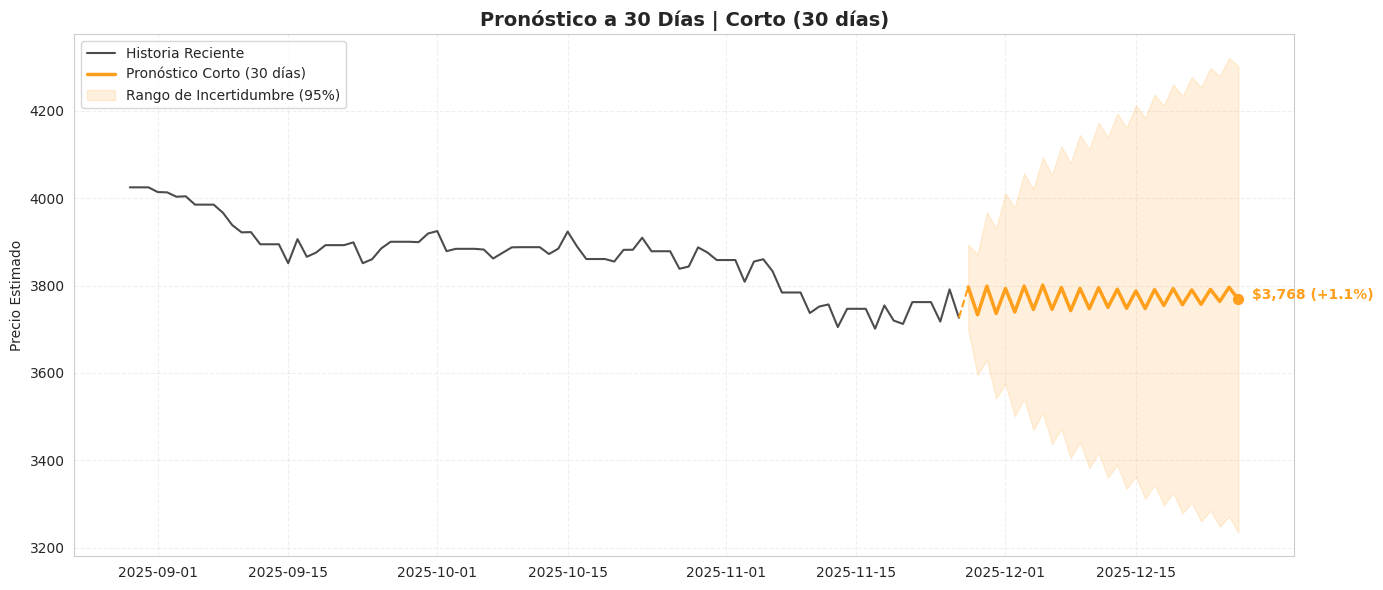


   ANÁLISIS DE ESCENARIO: MEDIO (90 DÍAS)

--- Primeros 5 días del pronóstico (Medio (90 días)) ---
            prediccion  lower_bound  upper_bound
fecha                                           
2025-11-27     3796.72      3699.29      3894.15
2025-11-28     3733.20      3595.41      3870.98
2025-11-29     3798.69      3629.94      3967.45
2025-11-30     3736.15      3541.29      3931.01
2025-12-01     3793.33      3575.47      4011.19
...


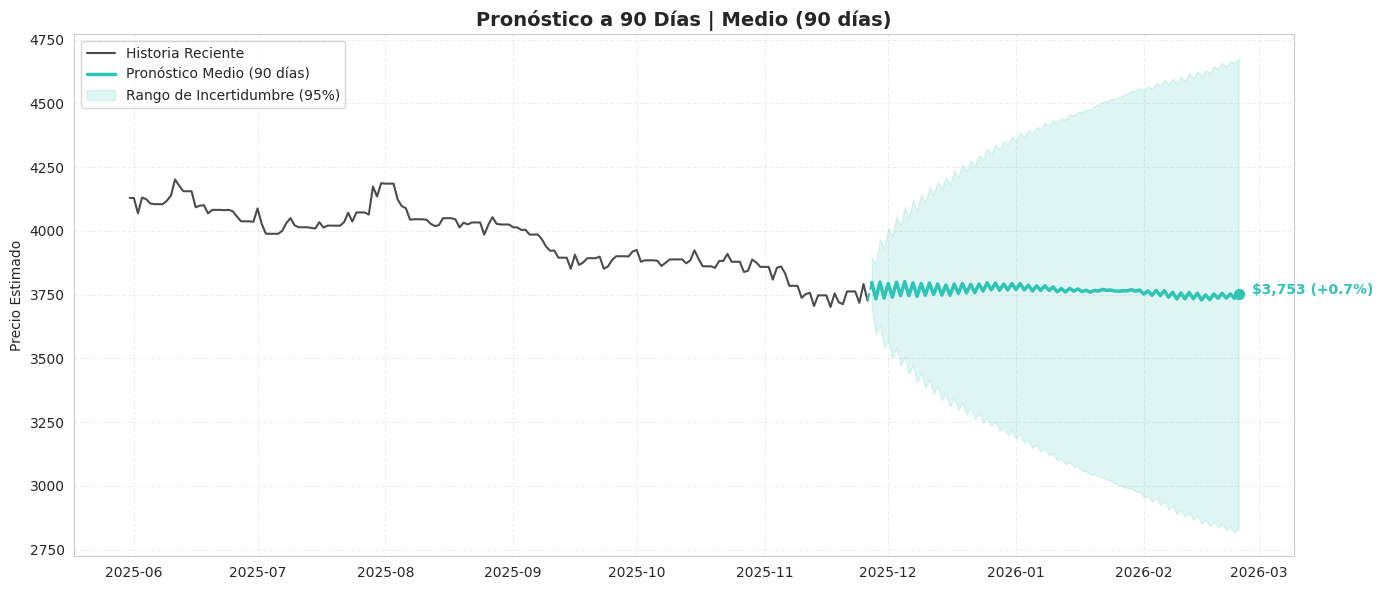


   ANÁLISIS DE ESCENARIO: LARGO (180 DÍAS)

--- Primeros 5 días del pronóstico (Largo (180 días)) ---
            prediccion  lower_bound  upper_bound
fecha                                           
2025-11-27     3796.72      3699.29      3894.15
2025-11-28     3733.20      3595.41      3870.98
2025-11-29     3798.69      3629.94      3967.45
2025-11-30     3736.15      3541.29      3931.01
2025-12-01     3793.33      3575.47      4011.19
...


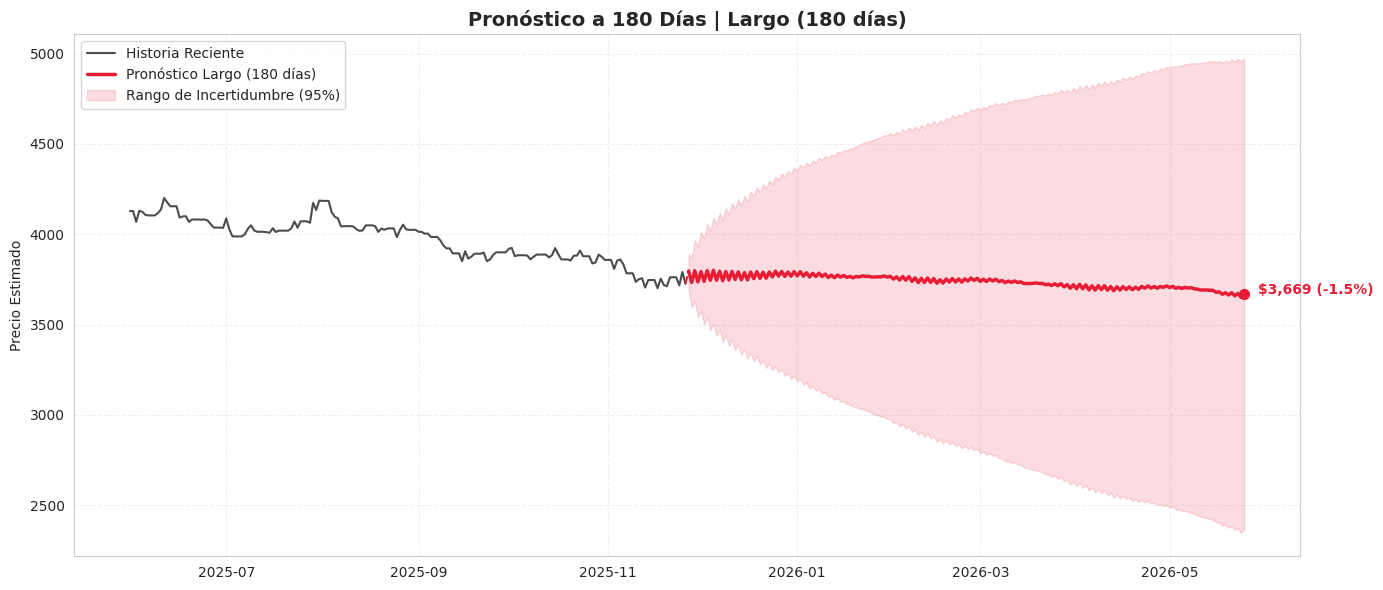

In [6]:
# Filtramos últimos 6 meses de historia real para el gráfico
historia_relevante = df_raw.iloc[-180:]
colores = ['#FF9F1C', '#2EC4B6', '#E71D36'] # Naranja, Turquesa, Rojo

# Iteramos sobre cada horizonte configurado para generar su reporte
for i, ((nombre, dias), color) in enumerate(zip(horizontes.items(), colores)):

    print(f"\n{'='*60}")
    print(f"   ANÁLISIS DE ESCENARIO: {nombre.upper()}")
    print(f"{'='*60}")

    # 1. Filtrar los datos correspondientes a este horizonte
    subset = df_preds.iloc[:dias]

    # 2. Mostrar la "Cabeza" de los datos (Head)
    print(f"\n--- Primeros 5 días del pronóstico ({nombre}) ---")
    display_cols = ['prediccion', 'lower_bound', 'upper_bound']
    print(subset[display_cols].head().round(2))
    print("...")

    # 3. Generar Gráfico Individual
    fig, ax = plt.subplots(figsize=(14, 6))

    # A. Datos Reales (Contexto)
    # Mostramos menos historia para los horizontes cortos para hacer "zoom" visual
    zoom_historia = 90 if dias <= 30 else 180
    historia_plot = df_raw.iloc[-zoom_historia:]

    ax.plot(historia_plot.index, historia_plot['precio'],
            label='Historia Reciente', color='black', linewidth=1.5, alpha=0.7)

    # B. Conector (Evitar huecos visuales)
    ultimo_real = historia_plot.iloc[-1]
    primera_pred = subset.iloc[0]
    ax.plot([ultimo_real.name, primera_pred.name],
            [ultimo_real['precio'], primera_pred['prediccion']],
            color=color, linestyle='--')

    # C. Línea de Pronóstico
    ax.plot(subset.index, subset['prediccion'],
            label=f'Pronóstico {nombre}', color=color, linewidth=2.5)

    # D. Banda de Confianza (Cono)
    ax.fill_between(subset.index, subset['lower_bound'], subset['upper_bound'],
                    color=color, alpha=0.15, label='Rango de Incertidumbre (95%)')

    # E. Anotaciones Finales
    precio_ini = historia_plot['precio'].iloc[-1]
    precio_fin = subset['prediccion'].iloc[-1]
    retorno = ((precio_fin - precio_ini) / precio_ini) * 100

    # Punto final y etiqueta
    ax.scatter([subset.index[-1]], [precio_fin], color=color, s=50)
    ax.annotate(f"${precio_fin:,.0f} ({retorno:+.1f}%)",
                xy=(subset.index[-1], precio_fin),
                xytext=(10, 0), textcoords="offset points",
                fontweight='bold', color=color)

    # Configuración del gráfico
    ax.set_title(f"Pronóstico a {dias} Días | {nombre}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Precio Estimado")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()